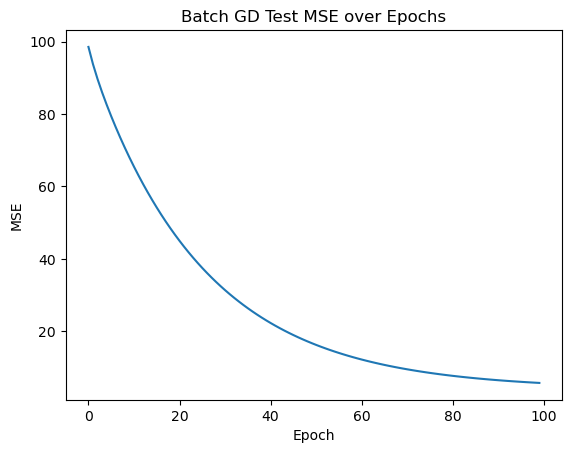

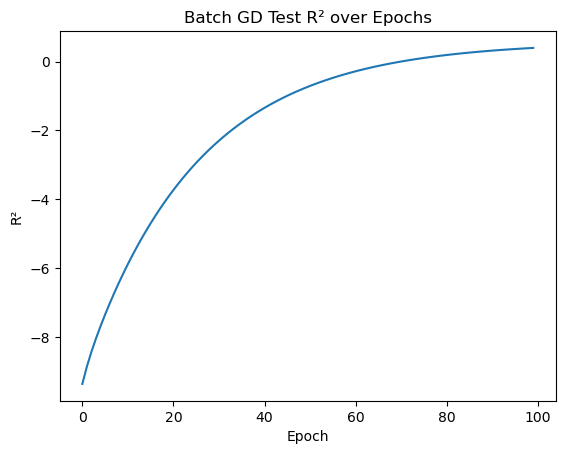

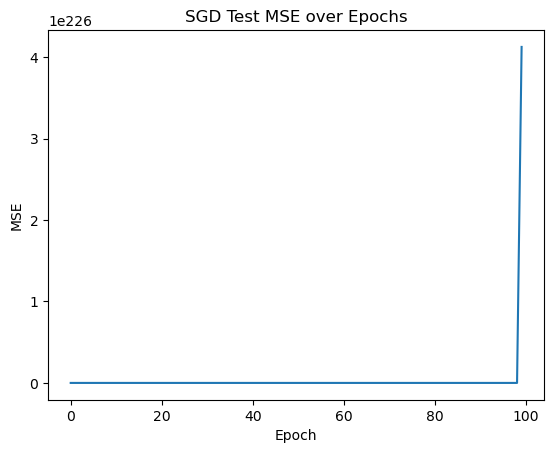

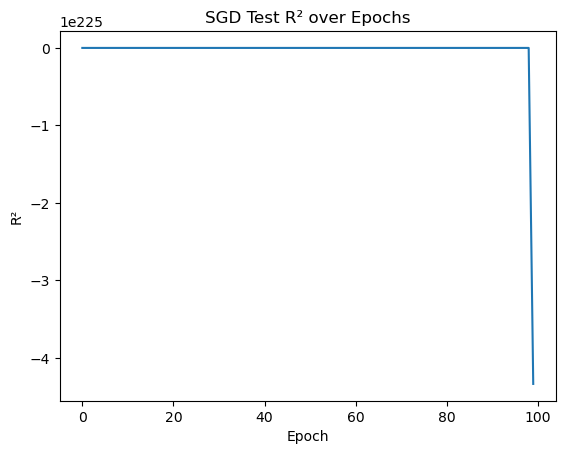

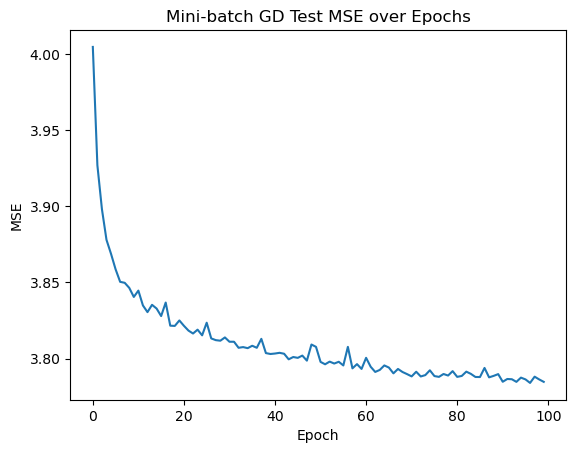

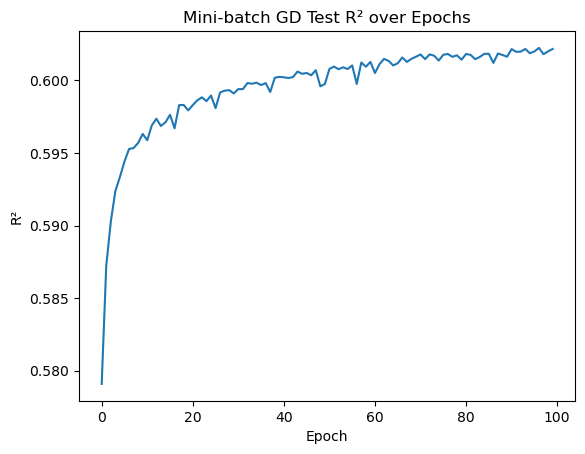

Final Test Performance:
Batch GD: MSE = 5.7456, R² = 0.3961
SGD: MSE = 41241387973182439127352817679659466819824503005010306284162642519712353110452794335266815484856538951776221642945232370456448683719686568027584551102208382346259262475814522769676926379386789683734053428311338037861566226890752.0000, R² = -4334955065849513861773709225412790344310347749741590542174146011689819807847543841186754712362649954291323236279070312055252300034963729092066235854797170397262856915626442637144875838716724690671759804285226473009945849626624.0000
Mini-batch GD: MSE = 3.7848, R² = 0.6022

Best model based on Test MSE: Mini-batch GD


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

# 1. Load and prepare data
df = pd.read_csv('train_newfeature.csv')
# select numeric features, exclude id and target
numeric = df.select_dtypes(include='number').columns.tolist()
features = [c for c in numeric if c not in ('id', 'Rings')]
X = df[features].values
y = df['Rings'].values

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize features
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

# 4. Gradient Descent implementations
def train_gd(X_tr, y_tr, X_te, y_te, lr, epochs, batch_size=None):
    n_samples, n_features = X_tr.shape
    w = np.zeros(n_features)
    b = 0.0
    history = {'test_mse': [], 'test_r2': []}
    
    for epoch in range(epochs):
        # shuffle for SGD/mini-batch
        if batch_size:
            idx = np.random.permutation(n_samples)
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                xb = X_tr[idx[start:end]]
                yb = y_tr[idx[start:end]]
                preds = xb.dot(w) + b
                err = preds - yb
                grad_w = (2/len(yb)) * xb.T.dot(err)
                grad_b = (2/len(yb)) * err.sum()
                w -= lr * grad_w
                b -= lr * grad_b
        else:
            preds = X_tr.dot(w) + b
            err = preds - y_tr
            grad_w = (2/n_samples) * X_tr.T.dot(err)
            grad_b = (2/n_samples) * err.sum()
            w -= lr * grad_w
            b -= lr * grad_b
        
        # evaluate on test set
        y_pred = X_te.dot(w) + b
        history['test_mse'].append(mean_squared_error(y_te, y_pred))
        history['test_r2'].append(r2_score(y_te, y_pred))
    
    return w, b, history

experiments = [
    ('Batch GD', {'lr': 0.01,  'batch_size': None}),
    ('SGD',      {'lr': 0.001, 'batch_size': 1}),
    ('Mini-batch GD', {'lr': 0.001, 'batch_size': 32}),
]

results = {}
for name, params in experiments:
    w, b, hist = train_gd(
        X_train_std, y_train, X_test_std, y_test,
        lr=params['lr'], epochs=100, batch_size=params['batch_size']
    )
    results[name] = (hist['test_mse'][-1], hist['test_r2'][-1])
    
    # Plot test MSE over epochs
    plt.figure()
    plt.plot(hist['test_mse'])
    plt.title(f'{name} Test MSE over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.show()
    
    # Plot test R² over epochs
    plt.figure()
    plt.plot(hist['test_r2'])
    plt.title(f'{name} Test R² over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('R²')
    plt.show()



# 6. Summarize and find best model
print("Final Test Performance:")
for name, (mse, r2) in results.items():
    print(f"{name}: MSE = {mse:.4f}, R² = {r2:.4f}")

best_model = min(results, key=lambda k: results[k][0])
print(f"\nBest model based on Test MSE: {best_model}")
